# Imports

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import itertools
import datetime
# Maybe use https://gitlab.com/mike01/pypacker or https://stackoverflow.com/questions/30826123/python-scapy-vs-dpkt
import scapy
import pickle
import subprocess
from subprocess import PIPE
from pathlib import Path
from datetime import datetime, timedelta
from scapy.all import *
import networkx as nx
import matplotlib.dates as mdates
import statistics
import re
import sharedVariables
from sharedVariables import *

In [2]:
# Datasets
dataset_sources = {
    'advanced': 'data/data-advanced-mongo-with-latency-3/20210922-17-experiment-advanced-mongo-with-latency-3',
    'baseline': 'data/data-baseline-with-latency-3/20210922-17-experiment-baseline-with-latency-3',
    'syncmesh': 'data/data-syncmesh-with-latency-3/20210922-17-experiment-syncmesh-with-latency-3'
}
print(ci)
ci = "true"
if ci == "true": 
    dataset_sources = {}
    print("Running CI Data detection")
    for folder in os.listdir("data"):
        if folder.startswith("data"):
            dashes = [m.start() for m in re.finditer('-', folder)]
            dataset_sources[folder[5:dashes[1]]] = "data/" + folder + "/" + os.listdir("data/" + folder)[0]
dataset_sources

Running CI Data detection


{'advanced': 'data/data-advanced-mongo-with-latency-3/20210926-12-experiment-advanced-mongo-with-latency-3',
 'syncmesh': 'data/data-syncmesh-with-latency-3/20210926-12-experiment-syncmesh-with-latency-3',
 'baseline': 'data/data-baseline-with-latency-3/20210926-12-experiment-baseline-with-latency-3'}

In [3]:
# Utility Functions
def to_human_readable(size, unit=True):
    power = 1000
    n = 0
    mem = {0 : 'B', 1: 'KB', 2: 'MB', 3: 'GB', 4: 'TB'}
    while size > power:
        size /=  power
        n += 1
    if unit:
        return "{0:.2f} {1}".format(size, mem[n])
    else:
        return "{0:.2f}".format(size)

In [4]:
ip_seperator

'92.60.39.199'

In [5]:
def filterDataForSeperator(df): 
    df = df[df["ip.src"].isin([ip_seperator, ip_client])]
    df = df[df["ip.dst"].isin([ip_seperator, ip_client])]
    df = df[(df["tcp.dstport"] == 443)] #  | (df["tcp.srcport"] == 443)
    return df

def filterDataForLocalTraffic(df): 
    df = df[df["ip.src"].str.contains(r'^10\.')]
    df = df[df["ip.dst"].str.contains(r'^10\.')]
    df = df[(df["tcp.dstport"] != 22) & (df["tcp.srcport"] != 22)]
    return df

def loadDataSet(folder):
    df_base = None
    for filename in os.listdir(folder):
        if filename.endswith(".csv") and filename.startswith("10"):
            csvfile = os.path.join(Path.cwd(), folder, filename)
            print(csvfile)
            EPOCH = datetime(1900, 1, 1)
            currentdf = pd.read_csv(csvfile)
            # print(len(currentdf))

            currentdf["frame.time_epoch"] = currentdf["frame.time_epoch"].apply(lambda x: datetime.utcfromtimestamp(float(x)))

            currentdf.set_index('frame.time_epoch', inplace=True)

            currentdf.dropna(inplace=True,subset=['ip.src', 'ip.dst'])
            # currentdf.to_csv(filename + ".csv")

            if (df_base is None):
                df_base = currentdf
            else:
                df_base = df_base.append(currentdf)

        else:
            continue

    seperatordf = filterDataForSeperator(df_base)
    timings = seperatordf.index.values
    # df_base.sort_index().to_csv("test.csv")
    # print(df_base)
    df_base = filterDataForLocalTraffic(df_base)
    return (df_base.sort_index(), timings)

datasets = {}
for source in dataset_sources:
    datasets[source] = loadDataSet(dataset_sources[source])
    
# test = loadDataSet("data/data-syncmesh-with-latency-3/20210922-17-experiment-syncmesh-with-latency-3")
datasets["advanced"][1]

/home/dnhb/Desktop/develop/syncmesh/evaluation/data/data-advanced-mongo-with-latency-3/20210926-12-experiment-advanced-mongo-with-latency-3/10.0.0.2.pcap.csv
/home/dnhb/Desktop/develop/syncmesh/evaluation/data/data-advanced-mongo-with-latency-3/20210926-12-experiment-advanced-mongo-with-latency-3/10.3.0.13.pcap.csv
/home/dnhb/Desktop/develop/syncmesh/evaluation/data/data-advanced-mongo-with-latency-3/20210926-12-experiment-advanced-mongo-with-latency-3/10.2.0.12.pcap.csv
/home/dnhb/Desktop/develop/syncmesh/evaluation/data/data-advanced-mongo-with-latency-3/20210926-12-experiment-advanced-mongo-with-latency-3/10.1.0.11.pcap.csv
/home/dnhb/Desktop/develop/syncmesh/evaluation/data/data-advanced-mongo-with-latency-3/20210926-12-experiment-advanced-mongo-with-latency-3/10.0.0.3.pcap.csv
/home/dnhb/Desktop/develop/syncmesh/evaluation/data/data-syncmesh-with-latency-3/20210926-12-experiment-syncmesh-with-latency-3/10.0.0.2.pcap.csv
/home/dnhb/Desktop/develop/syncmesh/evaluation/data/data-sync

array(['2021-09-26T12:06:01.513610000', '2021-09-26T12:09:24.906264000',
       '2021-09-26T12:13:06.669996000', '2021-09-26T12:17:04.761758000',
       '2021-09-26T12:21:34.742060000', '2021-09-26T12:24:53.209919000',
       '2021-09-26T12:28:11.921990000', '2021-09-26T12:31:30.813857000',
       '2021-09-26T12:34:50.226142000'], dtype='datetime64[ns]')

In [6]:
df = datasets["syncmesh"][0]
# df[(df['ip.src']=='10.1.0.11') & (df['ip.dst']=='10.2.0.12')]
# df[(df['ip.src']=='10.1.0.11')]
df

,tcp.analysis.initial_rtt,ip.id,ip.src,ip.dst,ip.len,tcp.srcport,tcp.dstport
frame.time_epoch,,,,,,,
2021-09-26 12:07:03.152936,NaN,0x0000c3e5,10.0.0.2,10.1.0.11,60.0,58798.0,8080.0
2021-09-26 12:07:03.167585,NaN,0x0000c3e5,10.0.0.2,10.1.0.11,60.0,58798.0,8080.0
2021-09-26 12:07:03.167630,NaN,0x00000000,10.1.0.11,10.0.0.2,60.0,8080.0,58798.0
2021-09-26 12:07:03.182059,NaN,0x00000000,10.1.0.11,10.0.0.2,60.0,8080.0,58798.0
2021-09-26 12:07:03.182098,0.029162,0x0000c3e6,10.0.0.2,10.1.0.11,52.0,58798.0,8080.0
...,...,...,...,...,...,...,...
2021-09-26 12:32:53.108507,0.116413,0x00001375,10.1.0.11,10.3.0.13,52.0,53686.0,8080.0
2021-09-26 12:32:53.115776,0.185536,0x000092a1,10.2.0.12,10.1.0.11,52.0,8080.0,41944.0
2021-09-26 12:32:53.166441,0.115575,0x00001375,10.1.0.11,10.3.0.13,52.0,53686.0,8080.0


In [7]:
def calcSubset(df):
    nodes = list(dict.fromkeys(df["ip.src"].unique().tolist() + df["ip.dst"].unique().tolist()))
    # print(nodes)
    betweenNodesDataset = {}
    nodeCombinations = list(itertools.combinations(nodes, r=2))
    for combination in nodeCombinations: 
        # print(combination)
        # print(df[df['ip.src']==combination[0] & df['ip.dst']==combination[1]])
        # Use both src_ip and dest_ip as they are not request related
        key = "between " + combination[0] + " and " + combination[1]
        betweenNodesDataset[key] = df[((df['ip.src']==str(combination[0])) & (df['ip.dst']==str(combination[1]))) | ((df['ip.src']==str(combination[1])) & (df['ip.dst']==str(combination[0])))]

    return betweenNodesDataset

node_datasets = {}
for key in datasets:
    node_datasets[key] = calcSubset(datasets[key][0])

setname = "syncmesh"
for key in node_datasets[setname]:
    print(key, ":", len(node_datasets[setname][key]))
    # print(node_datasets[setname][key])
    

between 10.0.0.2 and 10.1.0.11 : 19678
between 10.0.0.2 and 10.2.0.12 : 0
between 10.0.0.2 and 10.3.0.13 : 0
between 10.1.0.11 and 10.2.0.12 : 9452
between 10.1.0.11 and 10.3.0.13 : 9131
between 10.2.0.12 and 10.3.0.13 : 0


In [8]:
# Experiments
def splitExperiments(df, timings):
    experiments = ["collect1", "collect7", "collect14", "collect30", "aggregate1", "aggregate7", "aggregate14", "aggregate30"]
    return_data = {}
    for index, experiment in enumerate(experiments): 
        return_data[experiment] = calcSubset(df.loc[str(timings[index]):str(timings[index + 1])])
    return return_data

node_experiment_datasets = {}
for key in datasets:
    print(key)
    print(datasets[key][1])
    node_experiment_datasets[key] = splitExperiments(datasets[key][0], datasets[key][1])

setname = "syncmesh"
for key in node_experiment_datasets[setname]:
    print(key, ":", len(node_experiment_datasets[setname][key]))


advanced
['2021-09-26T12:06:01.513610000' '2021-09-26T12:09:24.906264000'
 '2021-09-26T12:13:06.669996000' '2021-09-26T12:17:04.761758000'
 '2021-09-26T12:21:34.742060000' '2021-09-26T12:24:53.209919000'
 '2021-09-26T12:28:11.921990000' '2021-09-26T12:31:30.813857000'
 '2021-09-26T12:34:50.226142000']
syncmesh
['2021-09-26T12:06:02.379763000' '2021-09-26T12:09:17.843738000'
 '2021-09-26T12:12:54.727942000' '2021-09-26T12:16:37.812228000'
 '2021-09-26T12:20:45.563999000' '2021-09-26T12:24:08.695817000'
 '2021-09-26T12:27:27.263568000' '2021-09-26T12:30:41.587727000'
 '2021-09-26T12:33:56.723701000']
baseline
['2021-09-26T12:06:02.134862000' '2021-09-26T12:09:24.711322000'
 '2021-09-26T12:12:55.755033000' '2021-09-26T12:16:34.883285000'
 '2021-09-26T12:20:33.387162000' '2021-09-26T12:23:55.411083000'
 '2021-09-26T12:27:21.914835000' '2021-09-26T12:30:52.450873000'
 '2021-09-26T12:34:32.070841000']
collect1 : 6
collect7 : 6
collect14 : 6
collect30 : 6
aggregate1 : 6
aggregate7 : 6
aggrega

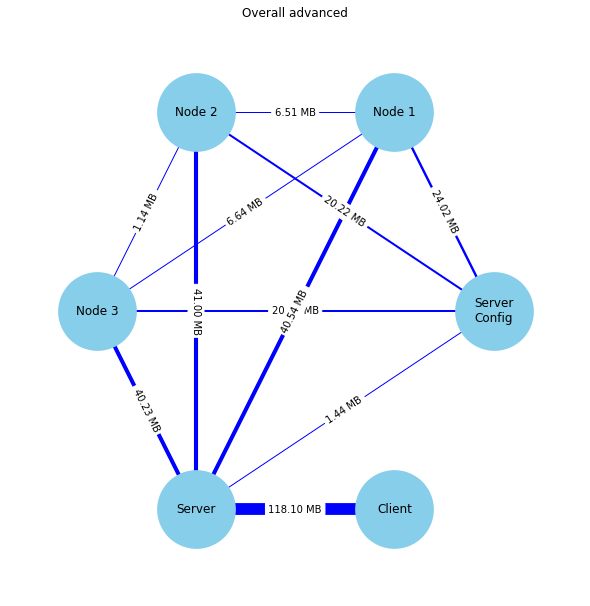

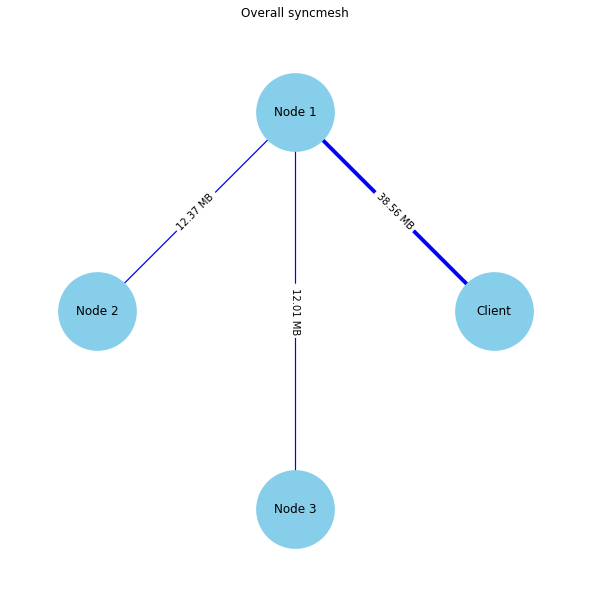

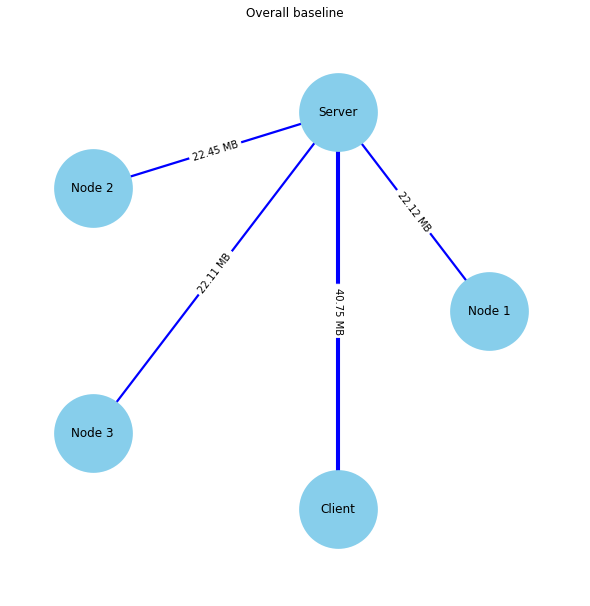

In [9]:
def get_node_name(ip):
    if(ip == "10.0.0.2"):
        return "Client"
    elif(ip == "10.0.0.3"):
        return "Server"
    elif(ip == "10.0.0.4"):
        return "Server\nConfig"
    elif(ip == "10.0.0.255"):
        return "ORCHESTRATOR"
    elif(ip.startswith("10.")):
        return "Node " + ip.split(".")[1]
    return ip

for index, subset_key in enumerate(node_datasets):
    G = nx.Graph()
    # print(subset_key)
    for node_dataset_key in node_datasets[subset_key]: 
        subset = node_datasets[subset_key][node_dataset_key]
        if len(subset["ip.dst"]) > 0:

            # if subset_key == "advanced":
                # print(node_dataset_key) 
                #print(subset["ip.src"].iloc[0], subset["ip.dst"].iloc[0]) 
                #print(get_node_name(subset["ip.src"].iloc[0]), get_node_name(subset["ip.dst"].iloc[0]))
            G.add_edge(get_node_name(subset["ip.src"].iloc[0]), get_node_name(subset["ip.dst"].iloc[0]), color='b', weight=np.clip(subset["ip.len"].sum()/10000000 , 1, 1000), label=to_human_readable(subset["ip.len"].sum()))
            #  + "\n" + "{:.0f}".format(subset["tcp.analysis.initial_rtt"].mean(skipna=True)* 1000) + "ms"

    pos = nx.circular_layout(G)

    size =8
    plt.figure(index+1,figsize=(size,size))
    edges = G.edges()
    colors = [G[u][v]['color'] for u,v in edges]
    weights = [G[u][v]['weight'] for u,v in edges]
    edgelabels = dict([((u, v), G[u][v]['label']) for u,v in edges])
    nx.draw(G, pos, edge_color=colors, width=weights, with_labels = True, node_size=1500, node_color="skyblue", node_shape="o", alpha=1, linewidths=40)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edgelabels)

    plt.axis('off')
    axis = plt.gca()
    axis.set_title("Overall " + subset_key)
    axis.set_xlim([1.2*x for x in axis.get_xlim()])
    axis.set_ylim([1.2*y for y in axis.get_ylim()])
    plt.savefig("out/network_"+subset_key+".png")
    

plt.show()

In [10]:
# node_experiment_datasets["syncmesh"]["aggregate30"]['between 10.2.0.12 and 10.1.0.11'].to_csv("test.csv")
# node_experiment_datasets["baseline"]["aggregate30"]['between 10.1.0.3 and 10.1.0.2'].to_csv("test2.csv")

collect1
between 10.0.0.4 and 10.3.0.13
between 10.0.0.4 and 10.1.0.11
between 10.0.0.4 and 10.2.0.12
between 10.0.0.4 and 10.0.0.3
between 10.3.0.13 and 10.1.0.11
between 10.3.0.13 and 10.2.0.12
between 10.3.0.13 and 10.0.0.3
between 10.1.0.11 and 10.2.0.12
between 10.1.0.11 and 10.0.0.3
between 10.2.0.12 and 10.0.0.3
between 10.0.0.3 and 10.0.0.2
collect7
between 10.1.0.11 and 10.2.0.12
between 10.1.0.11 and 10.0.0.4
between 10.1.0.11 and 10.3.0.13
between 10.1.0.11 and 10.0.0.3
between 10.2.0.12 and 10.0.0.4
between 10.2.0.12 and 10.3.0.13
between 10.2.0.12 and 10.0.0.3
between 10.0.0.4 and 10.3.0.13
between 10.0.0.4 and 10.0.0.3
between 10.3.0.13 and 10.0.0.3
between 10.0.0.3 and 10.0.0.2
collect14
between 10.1.0.11 and 10.2.0.12
between 10.1.0.11 and 10.0.0.4
between 10.1.0.11 and 10.3.0.13
between 10.1.0.11 and 10.0.0.3
between 10.2.0.12 and 10.0.0.4
between 10.2.0.12 and 10.3.0.13
between 10.2.0.12 and 10.0.0.3
between 10.0.0.4 and 10.3.0.13
between 10.0.0.4 and 10.0.0.3
between

/tmp/ipykernel_4731/1301179033.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(int(str(index)+str(e_index)))


aggregate14
between 10.1.0.11 and 10.0.0.3
between 10.0.0.3 and 10.2.0.12
between 10.0.0.3 and 10.3.0.13
between 10.0.0.3 and 10.0.0.2
aggregate30
between 10.1.0.11 and 10.0.0.3
between 10.0.0.3 and 10.2.0.12
between 10.0.0.3 and 10.3.0.13
between 10.0.0.3 and 10.0.0.2


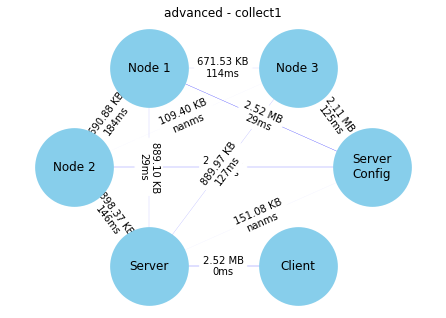

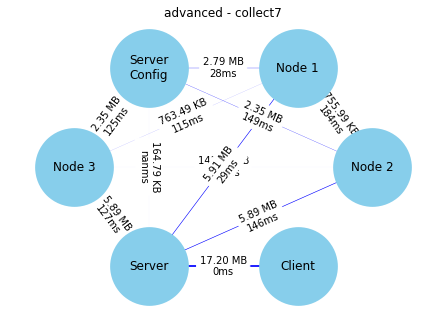

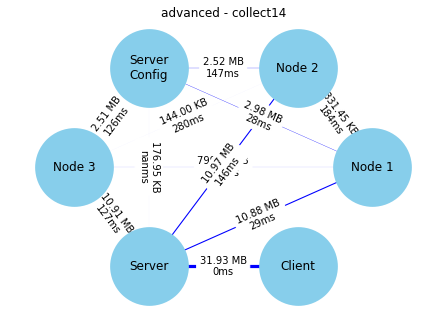

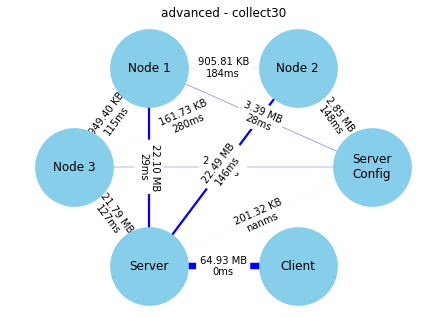

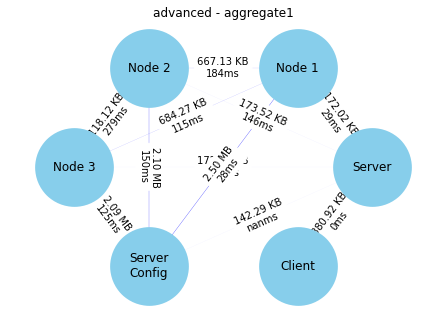

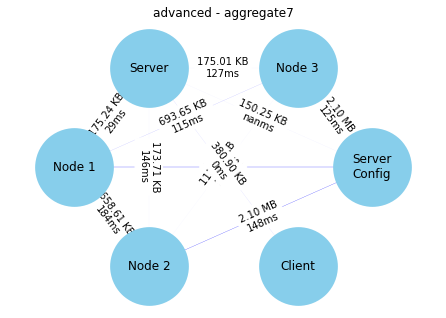

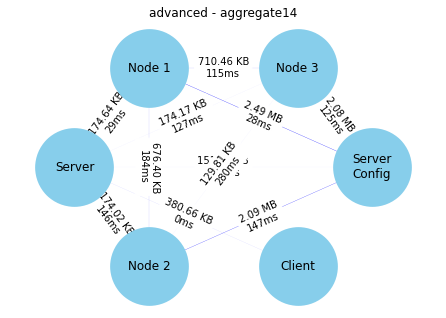

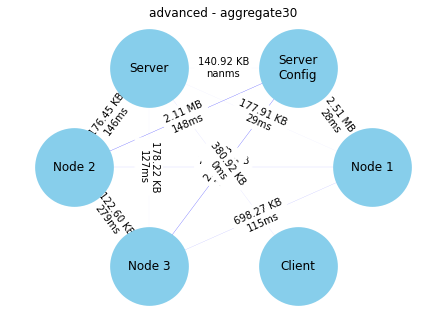

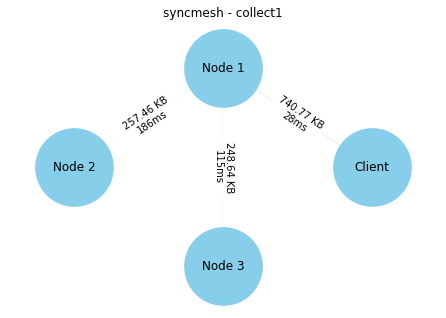

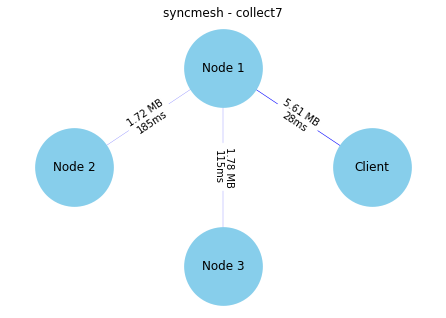

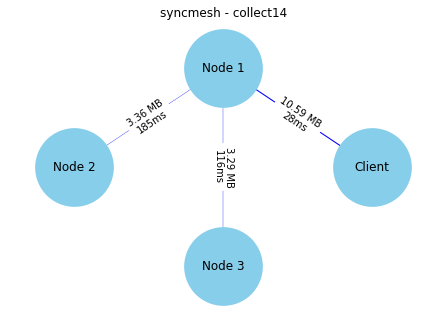

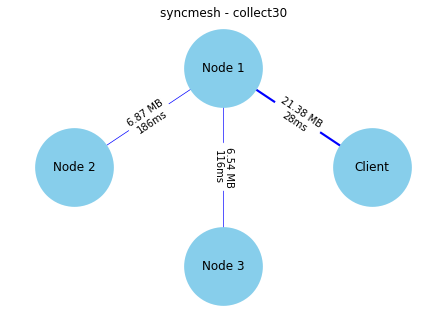

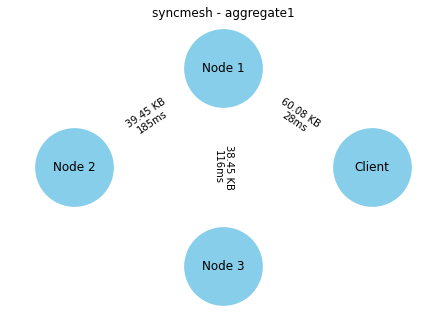

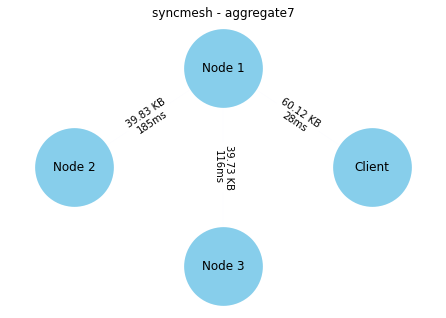

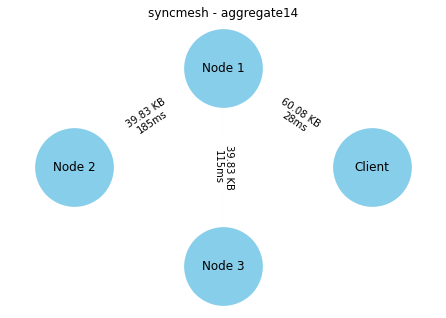

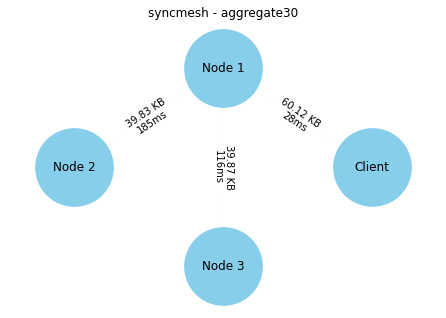

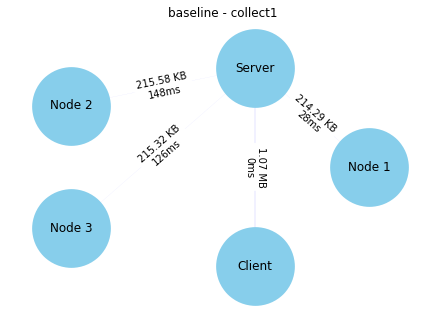

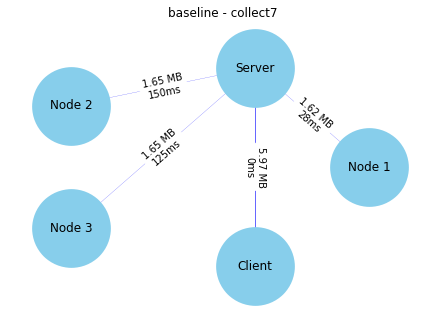

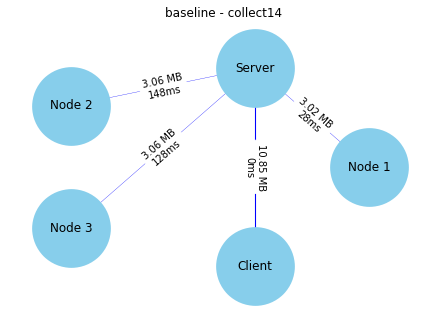

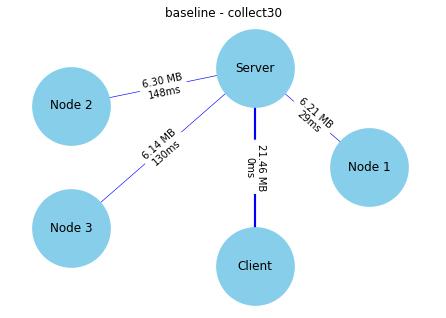

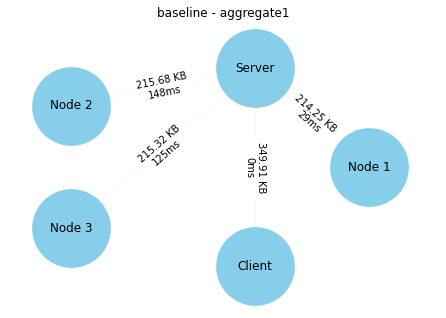

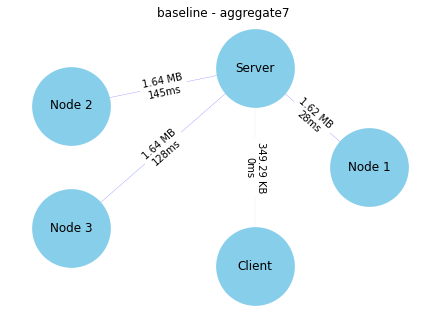

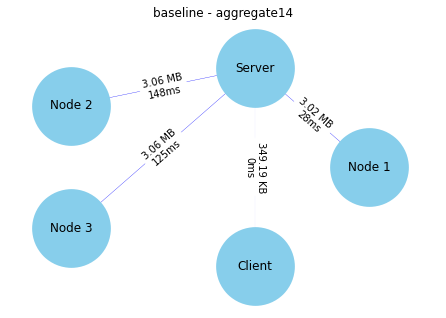

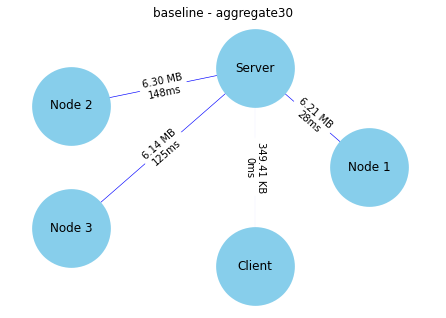

In [11]:
for index, subset_key in enumerate(node_experiment_datasets):
    # print(subset_key)
    for e_index, experiment_key in enumerate(node_experiment_datasets[subset_key]):
        print(experiment_key)
        G = nx.Graph()
        for node_dataset_key in node_experiment_datasets[subset_key][experiment_key]: 
            subset = node_experiment_datasets[subset_key][experiment_key][node_dataset_key]
            if len(subset["ip.dst"]) > 0:
                print(node_dataset_key) 
                G.add_edge(get_node_name(subset["ip.src"].iloc[0]), get_node_name(subset["ip.dst"].iloc[0]), color='b', weight=subset["ip.len"].sum()/10000000, label=to_human_readable(subset["ip.len"].sum()) + "\n" + "{:.0f}".format(subset["tcp.analysis.initial_rtt"].mean(skipna=True)* 1000) + "ms")
                # print(subset["tcp.analysis.initial_rtt"].mean()* 1000)

        pos = nx.circular_layout(G)

        plt.figure(int(str(index)+str(e_index)))
        edges = G.edges()
        colors = [G[u][v]['color'] for u,v in edges]
        weights = [G[u][v]['weight'] for u,v in edges]
        edgelabels = dict([((u, v), G[u][v]['label']) for u,v in edges])
        nx.draw(G, pos, edge_color=colors, width=weights, with_labels = True, node_size=1500, node_color="skyblue", node_shape="o", alpha=1, linewidths=40)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edgelabels)

        plt.axis('off')
        axis = plt.gca()
        axis.set_title(subset_key + " - " + experiment_key)
        axis.set_xlim([1.2*x for x in axis.get_xlim()])
        axis.set_ylim([1.2*y for y in axis.get_ylim()])
        plt.savefig("out/network_"+subset_key+"-"+experiment_key+".png")

# node_experiment_datasets
# plt.show()

In [12]:
from string import digits

s = 'abc123def456ghi789zero0'
remove_digits = str.maketrans('', '', digits)


subset_col = []
experiment_group_col = []
experiment_col = []
traffic_col = []
rtt_col = []
print("Aggregated Traffic")
for index, subset_key in enumerate(node_experiment_datasets):
    # print(subset_key)
    for e_index, experiment_key in enumerate(node_experiment_datasets[subset_key]):
        subset_col.append(subset_key)   
        experiment_group_col.append(experiment_key.translate(remove_digits))
        experiment_col.append(experiment_key)
        sum_bytes = 0
        for node_dataset_key in node_experiment_datasets[subset_key][experiment_key]: 
            subset = node_experiment_datasets[subset_key][experiment_key][node_dataset_key]
            sum_bytes = sum_bytes + subset["ip.len"].sum()

        traffic_col.append(sum_bytes)
        print(subset_key + " - " + experiment_key + ": " + to_human_readable(sum_bytes))

print("Median RTT")
for index, subset_key in enumerate(node_experiment_datasets):
    # print(subset_key)
    for e_index, experiment_key in enumerate(node_experiment_datasets[subset_key]):
        rtt = np.array([])
        for node_dataset_key in node_experiment_datasets[subset_key][experiment_key]: 
            subset = node_experiment_datasets[subset_key][experiment_key][node_dataset_key]
            rtt = np.append(rtt, subset["tcp.analysis.initial_rtt"].mean())

        # print(rtt)
        rtt_col.append(np.nanmean(rtt) * 1000)
        print(subset_key + " - " + experiment_key + ": " + str(np.nanmean(rtt) * 1000) + " msec " + str(statistics.median(rtt)))

Aggregated Traffic
advanced - collect1: 13.56 MB
advanced - collect7: 44.20 MB
advanced - collect14: 74.66 MB
advanced - collect30: 142.62 MB
advanced - aggregate1: 9.20 MB
advanced - aggregate7: 9.21 MB
advanced - aggregate14: 9.23 MB
advanced - aggregate30: 9.31 MB
syncmesh - collect1: 1.25 MB
syncmesh - collect7: 9.12 MB
syncmesh - collect14: 17.24 MB
syncmesh - collect30: 34.79 MB
syncmesh - aggregate1: 137.98 KB
syncmesh - aggregate7: 139.68 KB
syncmesh - aggregate14: 139.74 KB
syncmesh - aggregate30: 139.82 KB
baseline - collect1: 1.71 MB
baseline - collect7: 10.88 MB
baseline - collect14: 19.99 MB
baseline - collect30: 40.11 MB
baseline - aggregate1: 995.15 KB
baseline - aggregate7: 5.26 MB
baseline - aggregate14: 9.49 MB
baseline - aggregate30: 19.00 MB
Median RTT
advanced - collect1: 100.51774712080557 msec nan
advanced - collect7: 118.38436536636783 msec nan
advanced - collect14: 118.25690574790889 msec nan
advanced - collect30: 118.27368790495656 msec 0.14793746924829157
adv

In [13]:
analyze_table = pd.DataFrame(dict(experiment=subset_col,
scenario=experiment_group_col,
                  scenario_nodes=experiment_col,
                  traffic=traffic_col,
                  rtt=rtt_col))



sum_table = analyze_table.groupby(["experiment", "scenario"]).agg(
    traffic=("traffic", "sum"), rtt_mean=("rtt", "mean"))


sum_table.to_latex('sum_table.tex',)
def our_sort(index):
    print(index)
    # if index.name == "subset":
    print(index)
    return index 



# sum_table["rtt_mean"] = sum_table["rtt_mean"].apply(lambda x: "{:.0f} ({:+.2%})".format(x,(1-sum_table["rtt_mean"][2] / x )))
# sum_table["traffic"] = sum_table["traffic"].apply(lambda x: to_human_readable(x, False) + " ({:+.2%})".format(1-(sum_table["traffic"][2] / x )))
sum_table = sum_table.unstack(level=-1).reindex(['baseline', 'advanced', 'syncmesh'])

extra_table = sum_table.copy()
extra_table.columns = ['.'.join(col).strip() for col in sum_table.columns.values]

for scenario in ["aggregate", "collect"]:
    extra_table["rtt_mean." + scenario] = extra_table["rtt_mean." + scenario].apply(lambda x: "{:.0f} ({:+.1%})".format(x,(1-extra_table["rtt_mean." + scenario][0] / x )))
    extra_table["traffic." + scenario] = extra_table["traffic." + scenario].apply(lambda x: to_human_readable(x, False) + " ({:+.1%})".format(1-(extra_table["traffic." + scenario][0] / x )))
extra_extra_table = extra_table.columns.str.split('.', expand=True)

extra_table.columns = extra_extra_table

extra_table.rename(columns={"traffic": "Traffic (in MB)", "rtt_mean": "RTT (in ms)"}, inplace=True)
extra_table.to_latex("sum_table.tex")
extra_table
# print([tuple(col.split("%")) for col in sum_table.columns.values])


Traffic (in MB)                    RTT (in ms)              
                    aggregate          collect     aggregate       collect
experiment                                                                
baseline        34.74 (+0.0%)    72.69 (+0.0%)    75 (+0.0%)    76 (+0.0%)
advanced        36.95 (+6.0%)  275.05 (+73.6%)  118 (+36.1%)  114 (+33.2%)
syncmesh    557.21 (-6134.3%)   62.39 (-16.5%)  110 (+31.2%)  110 (+30.7%)

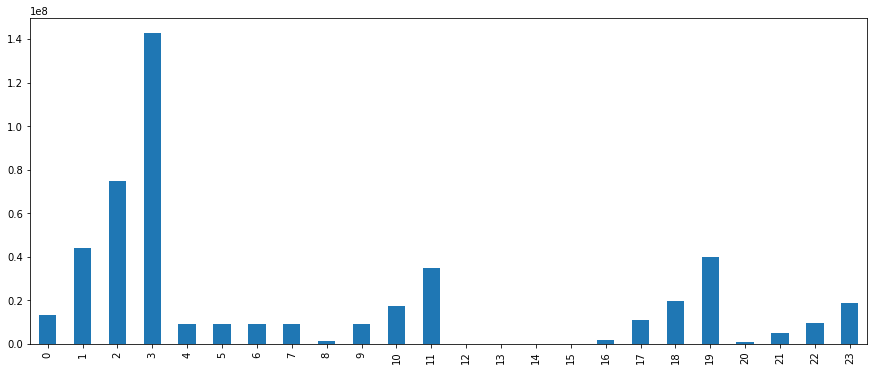

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

analyze_table['traffic'].plot.bar()

plt.show()
# This shows that the traffic is rising evenly accross multiple timeframes.

/tmp/ipykernel_4731/3467378951.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in


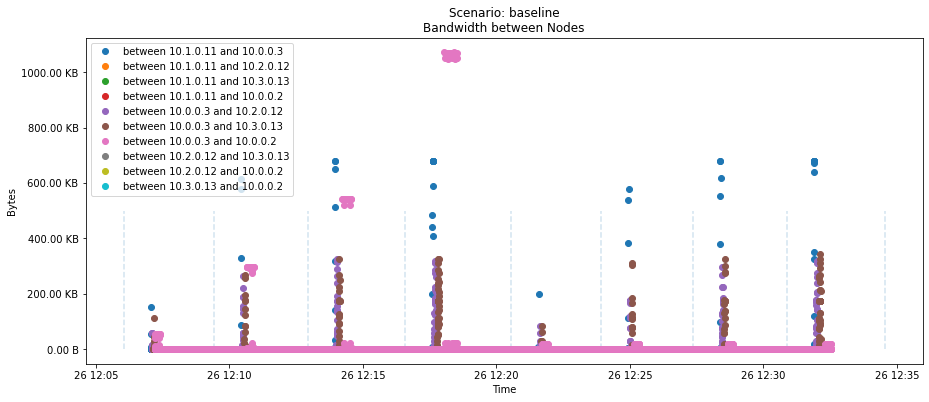

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
# ax.set_ylim(0,500)
dataset="baseline"
for key in node_datasets[dataset]: 
    test = node_datasets[dataset][key].resample('100ms').agg({"ip.len":'sum'})
    ax.plot(test.index, test["ip.len"], label=key, marker='o', linestyle='None')
# for key in fromClientDataset: 
#     test = fromClientDataset[key].resample('100ms').agg({"ip.len":'sum'})
#     ax.plot(test.index, test["ip.len"], label="to " + key, marker='o', linestyle='None')
# set title and legend

for timing in list(pd.to_datetime(datasets[dataset][1])): 
    ax.vlines(timing, 0, 500000, linestyle='--', alpha=0.2)
ax.set_title('Scenario: '+dataset+'\nBandwidth between Nodes')
ax.set_ylabel("Bytes")
ax.set_xlabel("Time")
box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.4, box.height])
ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in  
                    ax.get_yticks(minor=False)])
ax.legend(loc='upper left')

fig.savefig("out/bandwidth_between_nodes.png")
plt.show()

/tmp/ipykernel_4731/4238307838.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in


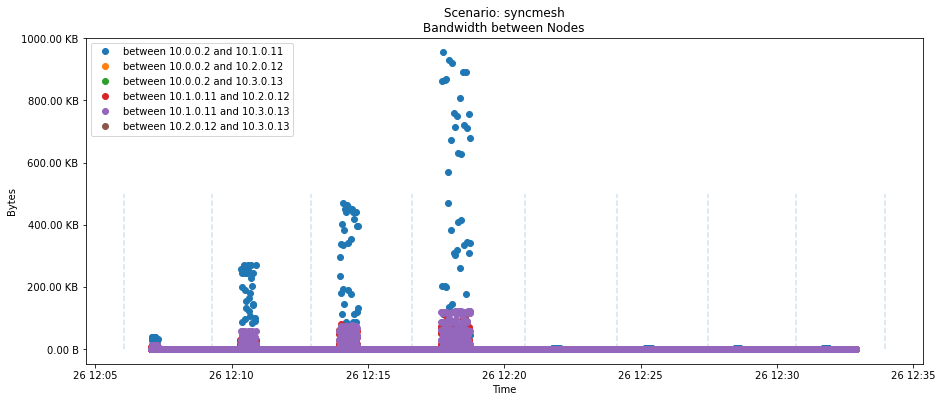

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
# ax.set_ylim(0,500)
dataset="syncmesh"
for key in node_datasets[dataset]: 
    test = node_datasets[dataset][key].resample('100ms').agg({"ip.len":'sum'})
    ax.plot(test.index, test["ip.len"], label=key, marker='o', linestyle='None')
# for key in fromClientDataset: 
#     test = fromClientDataset[key].resample('100ms').agg({"ip.len":'sum'})
#     ax.plot(test.index, test["ip.len"], label="to " + key, marker='o', linestyle='None')
# set title and legend

for timing in list(pd.to_datetime(datasets[dataset][1])): 
    ax.vlines(timing, 0, 500000, linestyle='--', alpha=0.2)
ax.set_title('Scenario: '+dataset+'\nBandwidth between Nodes')
ax.set_ylabel("Bytes")
ax.set_xlabel("Time")
box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.4, box.height])
ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in  
                    ax.get_yticks(minor=False)])
ax.legend(loc='upper left')

fig.savefig("out/bandwidth_between_nodes.png")
plt.show()

/tmp/ipykernel_4731/1540596556.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in


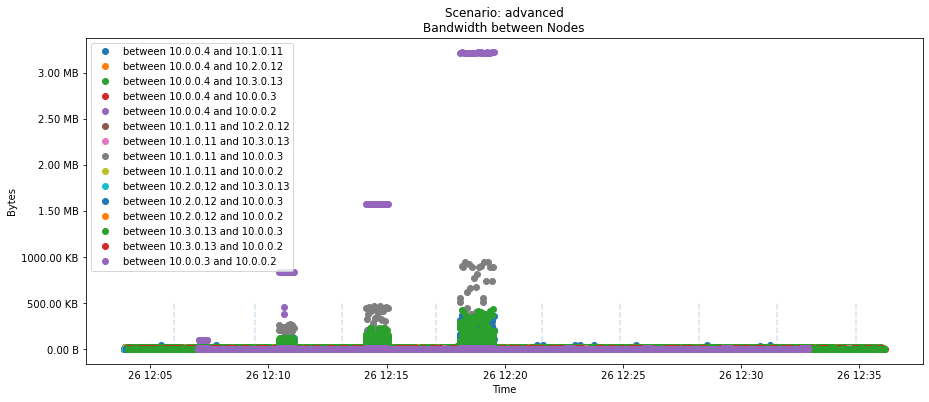

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
# ax.set_ylim(0,500)
dataset="advanced"
for key in node_datasets[dataset]: 
    test = node_datasets[dataset][key].resample('100ms').agg({"ip.len":'sum'})
    ax.plot(test.index, test["ip.len"], label=key, marker='o', linestyle='None')
# for key in fromClientDataset: 
#     test = fromClientDataset[key].resample('100ms').agg({"ip.len":'sum'})
#     ax.plot(test.index, test["ip.len"], label="to " + key, marker='o', linestyle='None')
# set title and legend

for timing in list(pd.to_datetime(datasets[dataset][1])): 
    ax.vlines(timing, 0, 500000, linestyle='--', alpha=0.2)
ax.set_title('Scenario: '+dataset+'\nBandwidth between Nodes')
ax.set_ylabel("Bytes")
ax.set_xlabel("Time")
box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.4, box.height])
ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in  
                    ax.get_yticks(minor=False)])
ax.legend(loc='upper left')

fig.savefig("out/bandwidth_between_nodes.png")
plt.show()

# Monitoring

In [18]:
def loadMonitoringDataSet(folder):
    csvfile = os.path.join(Path.cwd(), folder, "monitoring.csv")
    print(csvfile)
    df = pd.read_csv(csvfile)
    df.set_index('timestamp', inplace=True)
    df.index = pd.to_datetime(df.index)

    return df.sort_index()

monitoring_datasets = {}
for source in dataset_sources:
    monitoring_datasets[source] = loadMonitoringDataSet(dataset_sources[source])
    
# test = loadDataSet("data/data-syncmesh-with-latency-3/20210922-17-experiment-syncmesh-with-latency-3")
# monitoring_datasets["advanced"]

/home/dnhb/Desktop/develop/syncmesh/evaluation/data/data-advanced-mongo-with-latency-3/20210926-12-experiment-advanced-mongo-with-latency-3/monitoring.csv
/home/dnhb/Desktop/develop/syncmesh/evaluation/data/data-syncmesh-with-latency-3/20210926-12-experiment-syncmesh-with-latency-3/monitoring.csv
/home/dnhb/Desktop/develop/syncmesh/evaluation/data/data-baseline-with-latency-3/20210926-12-experiment-baseline-with-latency-3/monitoring.csv


In [19]:
# Experiments
def splitMonitoringExperiments(df, timings):
    experiments = ["collect1", "collect7", "collect14", "collect30", "aggregate1", "aggregate7", "aggregate14", "aggregate30"]
    return_data = {}
    for index, experiment in enumerate(experiments): 
        return_data[experiment] = df.loc[str(timings[index]):str(timings[index + 1])]
    return return_data

monitoring_experiment_datasets = {}
for key in monitoring_datasets:
    print(key)
    print(datasets[key][1])
    monitoring_experiment_datasets[key] = splitMonitoringExperiments(monitoring_datasets[key], datasets[key][1])

setname = "syncmesh"
for key in monitoring_experiment_datasets[setname]:
    print(key, ":", len(monitoring_experiment_datasets[setname][key]))


advanced
['2021-09-26T12:06:01.513610000' '2021-09-26T12:09:24.906264000'
 '2021-09-26T12:13:06.669996000' '2021-09-26T12:17:04.761758000'
 '2021-09-26T12:21:34.742060000' '2021-09-26T12:24:53.209919000'
 '2021-09-26T12:28:11.921990000' '2021-09-26T12:31:30.813857000'
 '2021-09-26T12:34:50.226142000']
syncmesh
['2021-09-26T12:06:02.379763000' '2021-09-26T12:09:17.843738000'
 '2021-09-26T12:12:54.727942000' '2021-09-26T12:16:37.812228000'
 '2021-09-26T12:20:45.563999000' '2021-09-26T12:24:08.695817000'
 '2021-09-26T12:27:27.263568000' '2021-09-26T12:30:41.587727000'
 '2021-09-26T12:33:56.723701000']
baseline
['2021-09-26T12:06:02.134862000' '2021-09-26T12:09:24.711322000'
 '2021-09-26T12:12:55.755033000' '2021-09-26T12:16:34.883285000'
 '2021-09-26T12:20:33.387162000' '2021-09-26T12:23:55.411083000'
 '2021-09-26T12:27:21.914835000' '2021-09-26T12:30:52.450873000'
 '2021-09-26T12:34:32.070841000']
collect1 : 3
collect7 : 3
collect14 : 4
collect30 : 4
aggregate1 : 4
aggregate7 : 3
aggrega

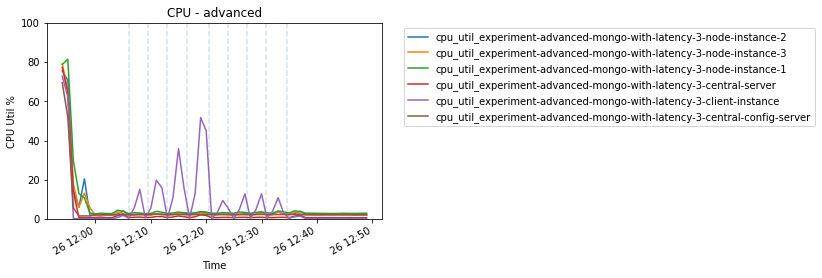

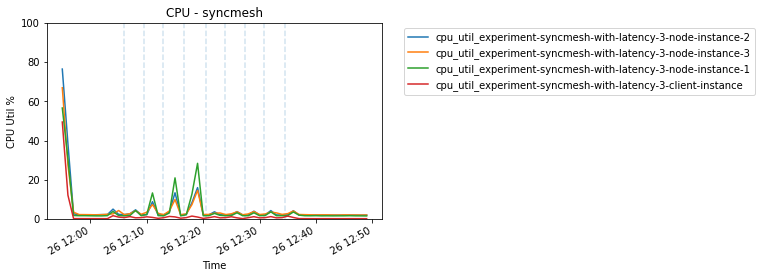

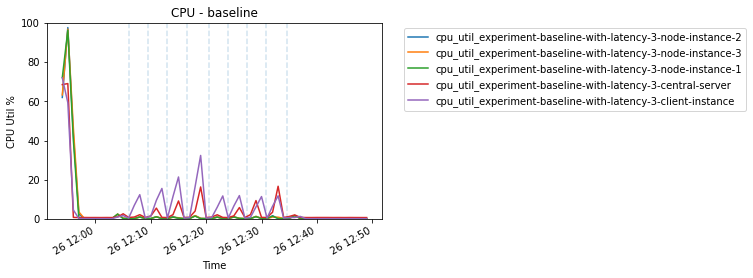

In [31]:
def drawMonitoringGraphCPU(df, name):
    columns = df.columns
    fig, ax = plt.subplots()
    ax.set_ylim(0,100)

    for col in columns: 
        if col.startswith("cpu_") and "orchestrator" not in col:
            ax.plot(df.index, df[col]*100, label=col)

    for timing in list(pd.to_datetime(datasets["baseline"][1])): 
        ax.vlines(timing, 0, 100, linestyle='--', alpha=0.2)
    # set title and legend
    ax.set_title('CPU - ' + name)
    ax.set_ylabel("CPU Util %")
    ax.set_xlabel("Time")
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    box = ax.get_position()
    # ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    fig.autofmt_xdate()

    fig.savefig("out/cpu_util_" + name + ".png")
    plt.show()

for source in monitoring_datasets:
    drawMonitoringGraphCPU(monitoring_datasets[source], source)


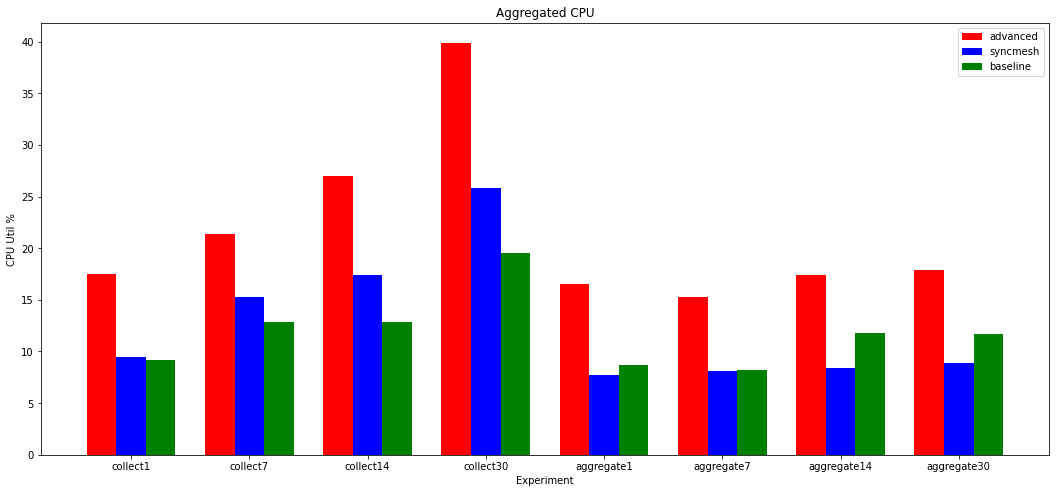

In [83]:
colors = ["r", "b", "g"]
def drawMonitoringCPUComparison(experiment_datasets):
    fig = plt.figure(figsize=(14, 6))
    ax = fig.add_axes([0,0,1,1])
    labels = np.array([])
    for index, source in enumerate(experiment_datasets):
        X = np.arange(len(experiment_datasets[source].keys()))
        X_labels = experiment_datasets[source].keys()
        labels = np.append(labels, source)
        sum_cpu_util = np.array([])
        for experiment in experiment_datasets[source]:
            df = experiment_datasets[source][experiment]
            columns = df.columns

            cpu_util = np.array([])
            num_instances = 0 
            for col in columns: 
                if col.startswith("cpu_") and "orchestrator" not in col:
                    # print(df[col])
                    num_instances = num_instances + 1
                    cpu_util = np.append(cpu_util, [df[col]])
                    # ax.plot(df.index, df[col]*100, label=col)
            # print(cpu_util)
            # print(np.mean(cpu_util))
            # See here for Formula for comparise
            sum_cpu_util = np.append(sum_cpu_util, np.mean(cpu_util) * num_instances)
        # print(sum_cpu_util)
        ax.bar(X - 0.25 + (0.25 * index), sum_cpu_util * 100, color = colors[index], width = 0.25)

    # set title and legend
    ax.set_title('Aggregated CPU')
    ax.set_ylabel("CPU Util %")
    ax.set_xlabel("Experiment")
    ax.legend(labels=labels)
    # box = ax.get_position()
    # # ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    # fig.autofmt_xdate()
    plt.xticks(X, X_labels)
    fig.savefig("out/cpu_comparison.png")
    plt.show()

drawMonitoringCPUComparison(monitoring_experiment_datasets)